# Fake Reviews Classification
---

In [1]:
# code sources
# [1] https://deeplizard.com/learn/video/HcW0DeWRggs

In [2]:
# importing requried libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import random as rn
import itertools

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional, GlobalAveragePooling1D

# importing a stylesheet library for visualisations
sns.set(style='white')

In [3]:
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
# setting seeds so results are reproducable [1] 
import os
os.environ['PYTHONHASHSEED'] = '0'
seed = 42069
np.random.seed(seed)
rn.seed(seed)
tf.random.set_seed(seed)

In [5]:
# loading the data from the csv file into a pandas' dataframe
dataframe = pd.read_csv("fake reviews dataset.csv")
dataframe.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


## Data preprocessing

Data is preprocessed by checking for null values, removing unnecessary columns, and adding new ones to help with exploratory data analysis 

In [6]:
print("number of null values: {}".format(dataframe.isnull().any(axis=1).sum()))

number of null values: 0


In [7]:
dataframe = dataframe.rename(columns={"text_":"text"}) # column rename
dataframe = dataframe.drop(["category"], axis=1) # remove category column

In [8]:
# added 2 new columns for EDA purposes
dataframe['text_length_char'] = dataframe['text'].apply(len) 
dataframe['text_length_word'] = dataframe['text'].apply(lambda x: len(x.split(' ')))
# renamed entries in label column for clarity 
dataframe['label'] = dataframe['label'].apply(lambda x: 'Fake' if x == "CG" else "Real")

# labels are encoded (0=fake, 1=real)
encoder = LabelEncoder()
encoder.fit(dataframe['label'])
dataframe['label_encoded'] = encoder.transform(dataframe['label'])
dataframe.head()

,rating,label,text,text_length_char,text_length_word,label_encoded
0,5.0,Fake,"Love this! Well made, sturdy, and very comfor...",75,14,0
1,5.0,Fake,"love it, a great upgrade from the original. I...",80,17,0
2,5.0,Fake,This pillow saved my back. I love the look and...,67,14,0
3,1.0,Fake,"Missing information on how to use it, but it i...",81,18,0
4,5.0,Fake,Very nice set. Good quality. We have had the s...,85,18,0


## Exploratory data analysis

EDA reveals that the classes are balanced (proportion of fake and real reviews are equal) and word distributions between the two are not very different (as evident by the word clouds). However, reviews are skewed towards positive ratings which will have implications for assessing the impact of review sentiment/polarity. Review lengths are also skewed, with most being comparitvely shorther. 

In [9]:
# displaying a sample of reviews 
print("Examples of reviews:\n")
for i in range(0, 40000, 10000):
    print(dataframe['text'][i])

Examples of reviews:

Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty
Just bought a couple more as back ups.  I really like this remote and it works well for what I need it for.  I emailed Audiovox and they confirmed that this is the exact same remote as the RCR314WR but this one costs less.
Exactly as advertised. It is sturdy, easy to assemble, and just right my 8 pound puppy.
One of the true great books written about war in Afghanistan. I must read for everyone, especially those who love true war stories. Excellent and amazing bravery among soldiers of Red Platoon.


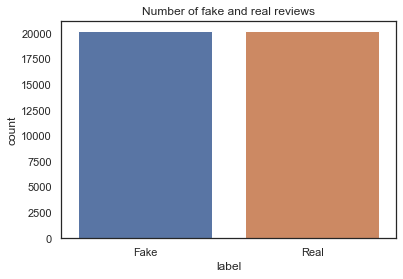

In [10]:
# dataset is balanced
sns.countplot(x = dataframe.label).set_title('Number of fake and real reviews');

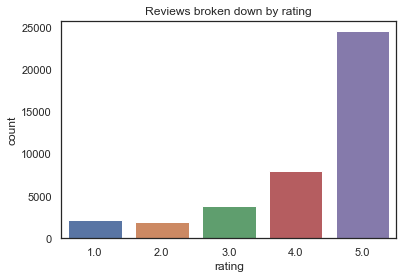

In [11]:
sns.countplot(x = dataframe.rating).set_title('Reviews broken down by rating');

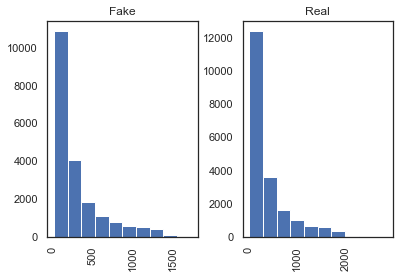

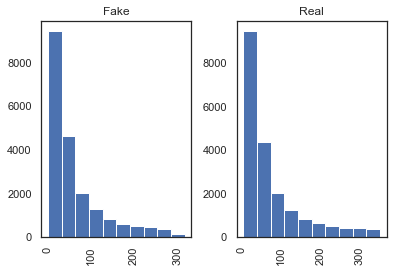

In [12]:
dataframe.hist(column='text_length_char', by='label');
dataframe.hist(column='text_length_word', by='label');
# spruce up? https://dataindependent.com/pandas/pandas-histogram-dataframe-hist/
# could do boxplots instead

In [13]:
print(max(dataframe['text_length_char']))
print(max(dataframe['text_length_word']))

2827
351


In [14]:
wc = WordCloud(
    background_color='white', 
    max_words=50)

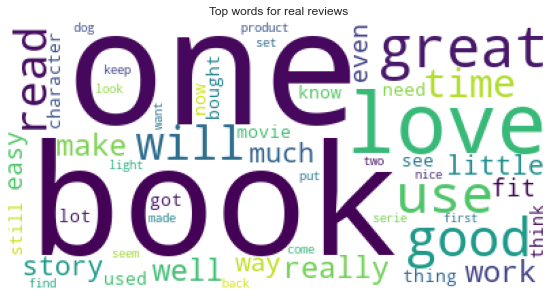

In [15]:
wc.generate(' '.join(text for text in dataframe.loc[dataframe['label'] == 'Real', 'text']))
plt.figure(figsize=(10,5))
plt.title('Top words for real reviews')
plt.imshow(wc)
plt.axis("off");

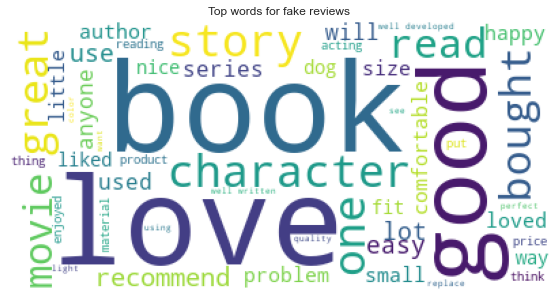

In [16]:
wc.generate(' '.join(text for text in dataframe.loc[dataframe['label'] == 'Fake', 'text']))
plt.figure(figsize=(10,5))
plt.title('Top words for fake reviews')
plt.imshow(wc)
plt.axis("off");

creatind data splits

In [17]:
x = dataframe["text"]
y = dataframe["label_encoded"]

In [18]:
# why to use train test split and stratify: https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, shuffle=True)

In [19]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(32345,) (8087,) (32345,) (8087,)


## Machine learning models

Before creting deep learning models using TensorFlow, standrad machine learning models are created using the Scikit learn library to establish a benchmark performance.

In [20]:
def naive(tfidf, n, smoothing):
    # https://kavita-ganesan.com/how-to-use-countvectorizer/
    if(tfidf==True):
        vectorizer = TfidfVectorizer(ngram_range=(n,n))
    else:
        vectorizer = CountVectorizer(ngram_range=(n,n)) 

    train_features = vectorizer.fit_transform(x_train)
    test_features = vectorizer.transform(x_test)

    NB = MultinomialNB(alpha=smoothing)
    NB.fit(train_features, y_train)

    return NB.score(test_features, y_test)

    #cm = metrics.confusion_matrix(y_test, pred)
    #print(cm)

In [21]:
%%time
ngrams = [1,2,3]
laplaces = [0.1, 1, 10]
NB_cv_results = []
NB_tf_results = []

for n,alpha in itertools.product(ngrams, laplaces):
    NB_cv_results.append(naive(False, n, alpha))

for n,alpha in itertools.product(ngrams, laplaces):
    NB_tf_results.append(naive(True, n, alpha))

CPU times: total: 1min 23s
Wall time: 1min 23s


In [22]:
NB_df = pd.DataFrame({'Ngrams': ['1', '1', '1', '2', '2', '2', '3', '3', '3'], 
                      'Alpha': ['0.1', '1', '10', '0.1', '1', '10', '0.1', '1', '10'],
                      'Count Vectorizer Acc': [NB_cv_results[0], NB_cv_results[1], NB_cv_results[2], NB_cv_results[3],
                                  NB_cv_results[4], NB_cv_results[5], NB_cv_results[6], NB_cv_results[7], NB_cv_results[8]],
                      'TFIDF Acc': [NB_tf_results[0], NB_tf_results[1], NB_tf_results[2], NB_tf_results[3], NB_tf_results[4], 
                                  NB_tf_results[5], NB_tf_results[6], NB_tf_results[7], NB_tf_results[8]]})

make below into subplots

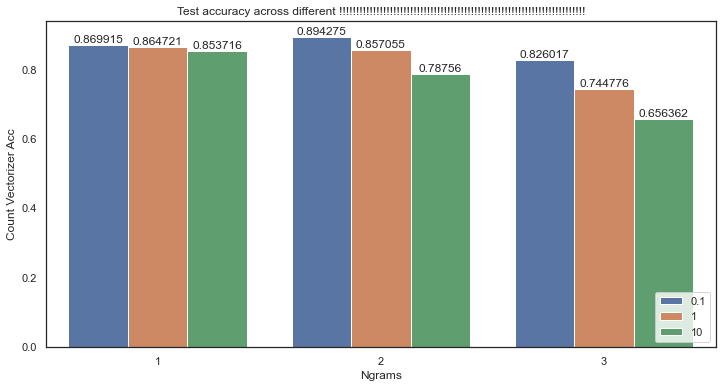

In [23]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Ngrams', y='Count Vectorizer Acc', hue='Alpha', data=NB_df);
ax.legend(loc='lower right')
ax.bar_label(ax.containers[0]); # format!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
ax.bar_label(ax.containers[1]);
ax.bar_label(ax.containers[2]);
plt.title('Test accuracy across different !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!');

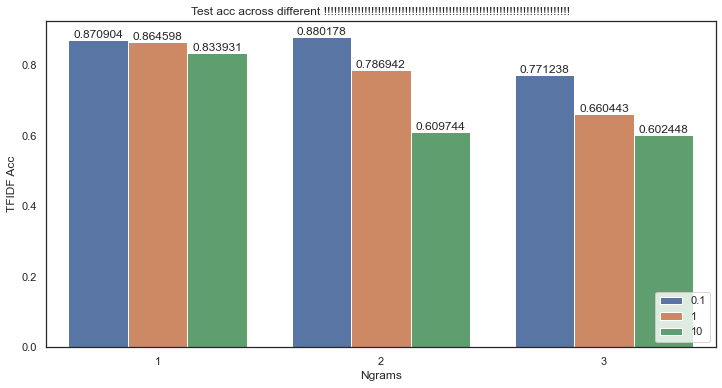

In [24]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Ngrams', y='TFIDF Acc', hue='Alpha', data=NB_df);
plt.legend(loc='lower right')
ax.bar_label(ax.containers[0]); # format!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
ax.bar_label(ax.containers[1]);
ax.bar_label(ax.containers[2]);
plt.title('Test acc across different !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!');

can show stopwords afer unneccessaey and presence show decrease so unneccesary

In [25]:
def naive2(cv):
    train_features = cv.fit_transform(x_train)
    test_features = cv.transform(x_test)
    NB = MultinomialNB(alpha=0.1)
    NB.fit(train_features, y_train)
    return NB.score(test_features, y_test)

In [26]:
cv = CountVectorizer(ngram_range=(2,2), stop_words="english")
print("Accuracy with stop words is: {}".format(naive2(cv)))
cv = CountVectorizer(ngram_range=(2,2), binary=True)
print("Accuracy with binary presence: (no counts) {}".format(naive2(cv)))

# could a graph here showing no improvement 

Accuracy with stop words is: 0.7854581426981575
Accuracy with binary presence: (no counts) 0.8889575862495362


### svm time

In [27]:
%%time

cv = CountVectorizer()
train_features = cv.fit_transform(x_train)
test_features = cv.transform(x_test)

c_values = [0.1, 0.5]

for c in c_values:
    linear_svm = svm.SVC(C=c)
    linear_svm.fit(train_features, y_train)
    print("accuracy is: ", linear_svm.score(test_features, y_test))

# just to make training times comparoable, lower values of c were used which may diminish accuracy. Contrary to many exosotog
# ... I find thta svms are the elast suitalle method 

accuracy is:  0.8412266600717201
accuracy is:  0.8871027575120564
CPU times: total: 8min 54s
Wall time: 8min 55s


## deep learning

In [28]:
# vocab size
# max sequence length

# word embedding type: keras or pre-trained
# optimiser and learning rate - => momentum,   https://www.google.co.uk/search?q=neural+network+optimizers&source=hp&ei=oNQbYpTrBNS_gQadlaeoAg&iflsig=AHkkrS4AAAAAYhvisAyGDsEGjAFqM9IFSWy-xLi33VpX&oq=neural+network+optim&gs_lcp=Cgdnd3Mtd2l6EAMYADIFCAAQgAQyBQgAEIAEMgUIABCABDIFCAAQgAQyBQgAEIAEMgUIABCABDIFCAAQgAQyBQgAEIAEMgUIABCABDIFCAAQgAQ6CwgAEIAEELEDEIMBOhEILhCABBCxAxCDARDHARCjAjoRCC4QgAQQsQMQgwEQxwEQ0QM6DgguEIAEELEDEMcBEKMCOg4ILhCABBCxAxDHARDRAzoOCC4QsQMQgwEQxwEQ0QM6CAgAELEDEIMBOgsILhCABBCxAxCDAToICAAQgAQQsQM6CwgAEIAEELEDEMkDOgUIABCSAzoRCC4QgAQQsQMQxwEQ0QMQ1AI6BQguEIAEUABYvh5g1CRoAHAAeACAAckBiAHSEpIBBjQuMTUuMZgBAKABAQ&sclient=gws-wiz&safe=active
# regularisation: dropout, bacthnormalisation, l2 regularisation
# neurons and layers -> bidirectionality

In [29]:
num_epochs = 25
val_split = 0.2

### start

In [30]:
# look at note1 for this section 

### end

sequence data needs to be handled

In [31]:
#https://www.youtube.com/watch?v=Y_hzMnRXjhI&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S&index=3
#tokenizer = Tokenizer(oov_token=oov_tok) # num_words = vocab_size , none == len(tokenizer.word_index) + 1
def tokenize(vocab_size):
    tokenizer = Tokenizer(oov_token = '<OOV>', num_words = vocab_size)
    tokenizer.fit_on_texts(x_train) # only fit to training data
    
    word_index = tokenizer.word_index
    
    # tokenizing training and testing 
    train_sequences = tokenizer.texts_to_sequences(x_train)
    test_sequences = tokenizer.texts_to_sequences(x_test)
        
    return train_sequences, test_sequences, word_index

In [32]:
def padding(max_length):
    # sequencing and padding on training and testing 
    train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length, truncating='post') 
    test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length, truncating='post')
    return train_padded, test_padded
    #print(train_padded.shape)

MLP is going to be tested on entire vocabulary with padding up to the length of the largest sequence. 

In [33]:
train_sequences, test_sequences, word_index = tokenize(None)

In [34]:
vocab_size = len(word_index)
print("Number of unique tokens in training data: {}".format(vocab_size)) # check how many words 

Number of unique tokens in training data: 39137


In [35]:
max_token_length = max([len(x) for x in train_sequences])
print("maximum tokenized sentence length in training data: {}".format(max_token_length))

maximum tokenized sentence length in training data: 521


In [36]:
train_padded, test_padded = padding(max_token_length)

# Before padding
print(len(train_sequences[0]), len(train_sequences[1]), len(test_sequences[0]), len(test_sequences[1]))
# After padding
print(len(train_padded[0]), len(train_padded[1]), len(test_padded[0]), len(test_padded[1]))

112 33 106 38
521 521 521 521


In [37]:
#train_padded[0]

In [38]:
# below mlp portion should be in ml section. use this over scikit learns mlp as greater flexibility 

In [39]:
# function is defined to build the model with different neurons (passed as a parameter)   
def build_mlp(neurons):
  mlp = tf.keras.models.Sequential([
    # dense layer
    tf.keras.layers.Dense(neurons, activation='relu'),
    # softmax layer with 10 neurons to classify the sample as one of the 10 classes
    tf.keras.layers.Dense(1, activation="sigmoid")
  ])
  mlp.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
  return mlp

# keras callbacks are used to implement early stopping. Validation accuracy is used as the metric and a minimum delta of 0.01 is
# specified (minimal increase in accuracy to be conisdered an improvement)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01, mode='max', restore_best_weights=True)

given the above, 64 seems to be the best choice which is what will be used in all dense layer going forward

In [40]:
# arrays to store each models results  
mlp_history, mlp_test_loss, mlp_test_acc = [], [], []

# batch sizes and learning rates that will be tested
batch_sizes = [32, 64, 128] 
neurons = [32, 64, 128] 

# nested for loops to iteratively create neural networks with different learning rates and batch sizes
for y in range(len(neurons)):
    mlp = build_mlp(neurons[y])
    for x in range(len(batch_sizes)):
        mlp_history.append(mlp.fit(train_padded, y_train, epochs=num_epochs, batch_size=batch_sizes[x], validation_split=0.2, 
                            shuffle=True, callbacks=[callback], verbose=1))                
        test_loss, test_acc = mlp.evaluate(test_padded,  y_test, verbose=0)
        mlp_test_loss.append(test_loss)
        mlp_test_acc.append(test_acc)

Epoch 1/25
809/809 [==============================] - 3s 3ms/step - loss: 48.0944 - accuracy: 0.5793 - val_loss: 16.5635 - val_accuracy: 0.5978
Epoch 2/25
809/809 [==============================] - 2s 3ms/step - loss: 6.6961 - accuracy: 0.6317 - val_loss: 3.6312 - val_accuracy: 0.6803
Epoch 3/25
809/809 [==============================] - 2s 3ms/step - loss: 1.5105 - accuracy: 0.7107 - val_loss: 1.4241 - val_accuracy: 0.7332
Epoch 4/25
809/809 [==============================] - 2s 3ms/step - loss: 0.8029 - accuracy: 0.7340 - val_loss: 0.9560 - val_accuracy: 0.7457
Epoch 5/25
809/809 [==============================] - 2s 3ms/step - loss: 0.6457 - accuracy: 0.7468 - val_loss: 0.8123 - val_accuracy: 0.7604
Epoch 6/25
809/809 [==============================] - 2s 3ms/step - loss: 0.5855 - accuracy: 0.7563 - val_loss: 0.6943 - val_accuracy: 0.7638
Epoch 7/25
809/809 [==============================] - 2s 3ms/step - loss: 0.5478 - accuracy: 0.7677 - val_loss: 0.7213 - val_accuracy: 0.7715
Epoc

809/809 [==============================] - 2s 3ms/step - loss: 1.9203 - accuracy: 0.7178 - val_loss: 2.3466 - val_accuracy: 0.7091
Epoch 5/25
809/809 [==============================] - 2s 3ms/step - loss: 1.4290 - accuracy: 0.7335 - val_loss: 2.3315 - val_accuracy: 0.6907
Epoch 6/25
809/809 [==============================] - 2s 3ms/step - loss: 1.2244 - accuracy: 0.7465 - val_loss: 1.7527 - val_accuracy: 0.7264
Epoch 7/25
809/809 [==============================] - 2s 3ms/step - loss: 1.0411 - accuracy: 0.7582 - val_loss: 1.6313 - val_accuracy: 0.7270
Epoch 8/25
809/809 [==============================] - 2s 3ms/step - loss: 0.9387 - accuracy: 0.7651 - val_loss: 1.4193 - val_accuracy: 0.7344
Epoch 9/25
809/809 [==============================] - 2s 3ms/step - loss: 0.7708 - accuracy: 0.7721 - val_loss: 1.1541 - val_accuracy: 0.7486
Epoch 10/25
809/809 [==============================] - 2s 3ms/step - loss: 0.7041 - accuracy: 0.7770 - val_loss: 1.1268 - val_accuracy: 0.7544
Epoch 11/25
809/

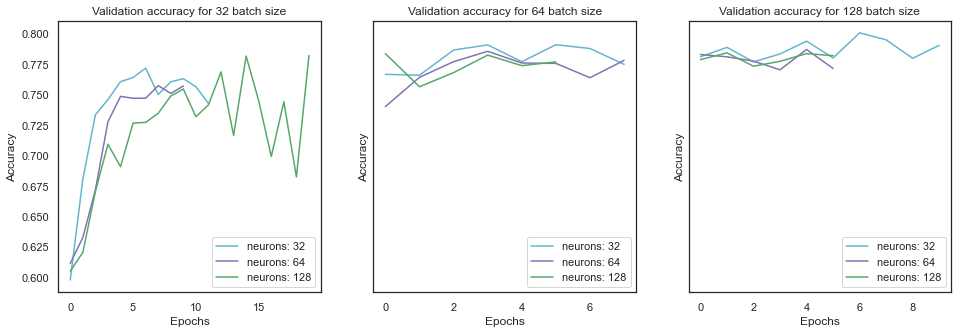

In [41]:
# three line charts to show the progression of the validation accuracy across each model for each batch size and learning rate
fig, axs = plt.subplots(1,3,figsize=(16,5), sharey = True)
# plot 1
axs[0].plot(mlp_history[0].history['val_accuracy'],'c') 
axs[0].plot(mlp_history[3].history['val_accuracy'],'m')
axs[0].plot(mlp_history[6].history['val_accuracy'],'g')
axs[0].set_title('Validation accuracy for 32 batch size')
axs[0].set_ylabel('Accuracy') 
axs[0].set_xlabel('Epochs')
axs[0].legend(['neurons: 32', 'neurons: 64', 'neurons: 128'], loc='lower right')
# plot 2
axs[1].plot(mlp_history[1].history['val_accuracy'],'c') 
axs[1].plot(mlp_history[4].history['val_accuracy'],'m')
axs[1].plot(mlp_history[7].history['val_accuracy'],'g')
axs[1].set_title('Validation accuracy for 64 batch size')
axs[1].set_ylabel('Accuracy') 
axs[1].set_xlabel('Epochs')
axs[1].legend(['neurons: 32', 'neurons: 64', 'neurons: 128'], loc='lower right')
# plot 3
axs[2].plot(mlp_history[2].history['val_accuracy'],'c') 
axs[2].plot(mlp_history[5].history['val_accuracy'],'m')
axs[2].plot(mlp_history[8].history['val_accuracy'],'g')
axs[2].set_title('Validation accuracy for 128 batch size')
axs[2].set_ylabel('Accuracy') 
axs[2].set_xlabel('Epochs')
axs[2].legend(['neurons: 32', 'neurons: 64', 'neurons: 128'], loc='lower right')
plt.show()

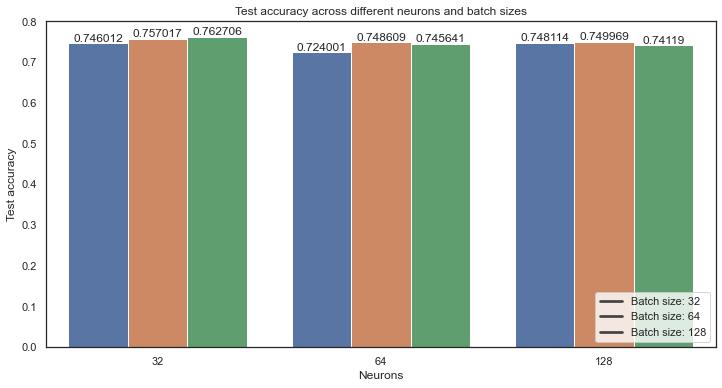

In [42]:
tempdf = pd.DataFrame({'Neurons': ['32', '32', '32', '64', '64', '64', '128', '128', '128'],
                       'Batch Size': ['32', '64', '128', '32', '64', '128', '32', '64', '128'],
                       'Test accuracy': [mlp_test_acc[0], mlp_test_acc[1], mlp_test_acc[2], mlp_test_acc[3], mlp_test_acc[4], 
                                         mlp_test_acc[5], mlp_test_acc[6], mlp_test_acc[7], mlp_test_acc[8]],
                       'Test loss': [mlp_test_loss[0], mlp_test_loss[1], mlp_test_loss[2], mlp_test_loss[3], mlp_test_loss[4], 
                                         mlp_test_loss[5], mlp_test_loss[6], mlp_test_loss[7], mlp_test_loss[8]]})

plt.figure(figsize=(12,6))
ax = sns.barplot(x='Neurons', y='Test accuracy', hue='Batch Size', data=tempdf);
plt.legend(["Batch size: 32", "Batch size: 64", "Batch size: 128"], loc='lower right')
ax.bar_label(ax.containers[0]); # format!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
ax.bar_label(ax.containers[1]);
ax.bar_label(ax.containers[2]);
plt.title('Test accuracy across different neurons and batch sizes');

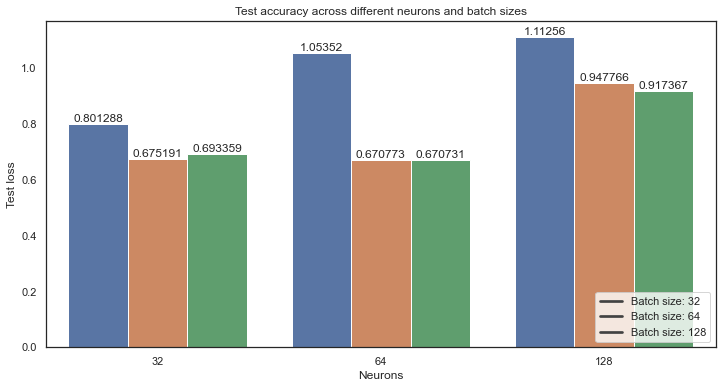

In [43]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Neurons', y='Test loss', hue='Batch Size', data=tempdf);
plt.legend(["Batch size: 32", "Batch size: 64", "Batch size: 128"], loc='lower right')
ax.bar_label(ax.containers[0]); # format!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
ax.bar_label(ax.containers[1]);
ax.bar_label(ax.containers[2]);
plt.title('Test accuracy across different neurons and batch sizes');

In [44]:
# given length distribtuons, it is not good to pad to largest sequence 

In [45]:
# trunicating is set to post as gpt models can produce outputs that become/have higher likelihood of becoming, nonsensical 
# towards the end. Thus, retaining trunicaintg earlier seq information = more robust model as problem is more challenging

In [46]:
## oov token is set to retain order/structure of seq?

In [47]:
# lower num words/vocab size will increase oov if has been set. too many oovs is not good becaus all have same context
# However, Means get less words but more likely to filter out info that is not really sueful to classification

In [48]:
# alternatives to oov exist such as work by: https://arxiv.org/pdf/1707.06961.pdf but improvments in results were mot
# substantial enough to warrent/justify the additional computational cost which would increase the training time 

In [49]:
# function is defined to build the model with different neurons (passed as a parameter)   
def build_lstm_1(neurons, vocab_size, embed_dim, max_length):
  lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length),
    tf.keras.layers.LSTM(neurons, return_sequences=False, activation='tanh'), 
    tf.keras.layers.Dense(1, activation="sigmoid")
  ])
  lstm_1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
  return lstm_1

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01, mode='max', restore_best_weights=True)

In [50]:
# arrays to store each models results  
lstm_history, lstm_test_loss, lstm_test_acc = [], [], []

neurons = [32, 64, 128] 
# nested for loops to iteratively create neural networks with different ... and batch sizes
for y in range(len(neurons)):
    lstm = build_lstm_1(neurons[y], vocab_size+1, 16, max_token_length)        
    lstm_history.append(lstm.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=1))                
    test_loss, test_acc = lstm.evaluate(test_padded, y_test, verbose=2)
    lstm_test_loss.append(test_loss)
    lstm_test_acc.append(test_acc)

Epoch 1/25
203/203 [==============================] - 11s 44ms/step - loss: 0.6932 - accuracy: 0.5026 - val_loss: 0.6931 - val_accuracy: 0.5021
Epoch 2/25
203/203 [==============================] - 8s 42ms/step - loss: 0.6932 - accuracy: 0.4963 - val_loss: 0.6931 - val_accuracy: 0.5021
Epoch 3/25
203/203 [==============================] - 9s 42ms/step - loss: 0.6932 - accuracy: 0.4968 - val_loss: 0.6933 - val_accuracy: 0.4979
Epoch 4/25
203/203 [==============================] - 8s 41ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6932 - val_accuracy: 0.4979
Epoch 5/25
203/203 [==============================] - 9s 43ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.5021
Epoch 6/25
203/203 [==============================] - 8s 41ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4979
253/253 - 4s - loss: 0.6931 - accuracy: 0.5003 - 4s/epoch - 17ms/step
Epoch 1/25
203/203 [==============================] - 12s 52ms/step - l

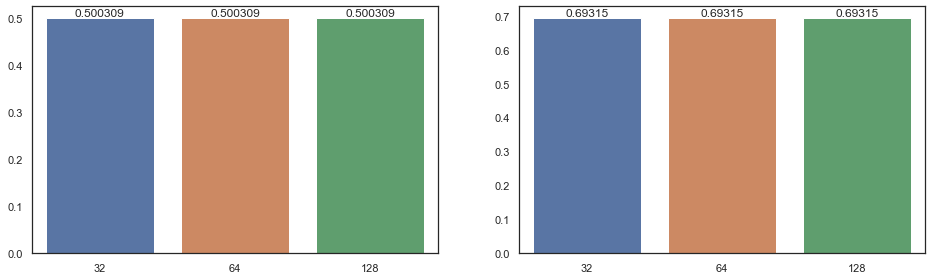

In [51]:
fig, axs = plt.subplots(1,2,figsize=(16,10))
plt.subplot(221)
ax = sns.barplot(x=neurons, y=lstm_test_acc);
ax.bar_label(ax.containers[0]);
plt.subplot(222)
ax = sns.barplot(x=neurons, y=lstm_test_loss);
ax.bar_label(ax.containers[0]);
#plt.show()

In [52]:
# arrays to store each models results  
lstm_history, lstm_test_loss, lstm_test_acc = [], [], []

max_lengths = [10, 25, 50, 100, 250] 
# nested for loops to iteratively create neural networks with different ... and batch sizes
for y in range(len(max_lengths)):
    train_padded, test_padded = padding(max_lengths[y])
    lstm = build_lstm_1(32, vocab_size+1, 16, max_lengths[y])        
    lstm_history.append(lstm.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0))                
    test_loss, test_acc = lstm.evaluate(test_padded, y_test, verbose=2)
    lstm_test_loss.append(test_loss)
    lstm_test_acc.append(test_acc)

253/253 - 1s - loss: 0.3714 - accuracy: 0.8339 - 520ms/epoch - 2ms/step
253/253 - 1s - loss: 0.2021 - accuracy: 0.9209 - 741ms/epoch - 3ms/step
253/253 - 1s - loss: 0.2195 - accuracy: 0.9164 - 835ms/epoch - 3ms/step
253/253 - 1s - loss: 0.2101 - accuracy: 0.9179 - 1s/epoch - 5ms/step
253/253 - 2s - loss: 0.5256 - accuracy: 0.7735 - 2s/epoch - 10ms/step


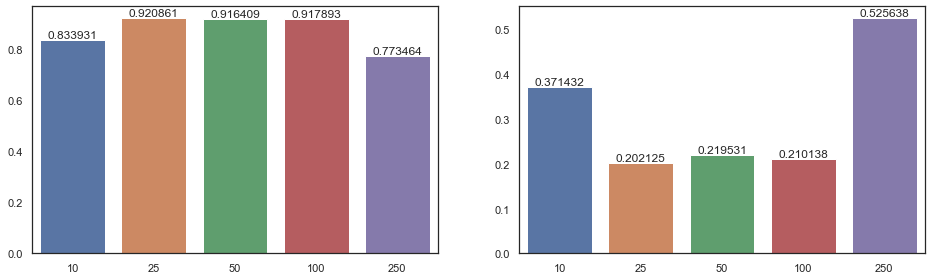

In [53]:
fig, axs = plt.subplots(1,2,figsize=(16,10))
plt.subplot(221)
ax = sns.barplot(x=max_lengths, y=lstm_test_acc);
ax.bar_label(ax.containers[0]);
plt.subplot(222)
ax = sns.barplot(x=max_lengths, y=lstm_test_loss);
ax.bar_label(ax.containers[0]);
#plt.show()

In [54]:
# arrays to store each models results  
lstm_history, lstm_test_loss, lstm_test_acc = [], [], []

vocab_sizes = [1000, 5000, 10000, 25000, 35000] 
# nested for loops to iteratively create neural networks with different ... and batch sizes
for y in range(len(vocab_sizes)):
    
    train_sequences, test_sequences, word_index = tokenize(vocab_sizes[y])
    train_padded, test_padded = padding(50)
    
    lstm = build_lstm_1(32, vocab_sizes[y], 16, 50)        
    lstm_history.append(lstm.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0))                
    test_loss, test_acc = lstm.evaluate(test_padded, y_test, verbose=2)
    lstm_test_loss.append(test_loss)
    lstm_test_acc.append(test_acc)

253/253 - 1s - loss: 0.1921 - accuracy: 0.9214 - 876ms/epoch - 3ms/step
253/253 - 1s - loss: 0.1781 - accuracy: 0.9316 - 859ms/epoch - 3ms/step
253/253 - 1s - loss: 0.2123 - accuracy: 0.9146 - 944ms/epoch - 4ms/step
253/253 - 1s - loss: 0.1789 - accuracy: 0.9319 - 771ms/epoch - 3ms/step
253/253 - 1s - loss: 0.1836 - accuracy: 0.9268 - 888ms/epoch - 4ms/step


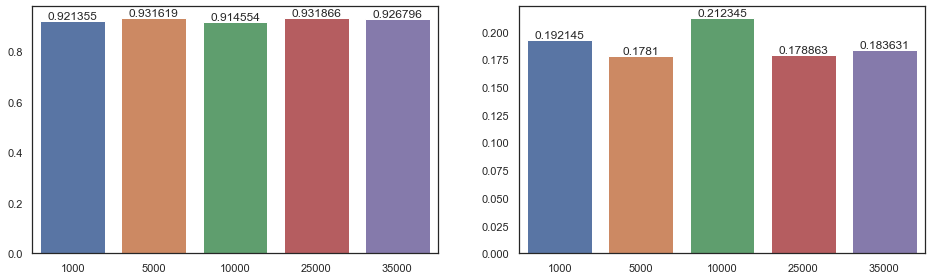

In [55]:
fig, axs = plt.subplots(1,2,figsize=(16,10))
plt.subplot(221)
ax = sns.barplot(x=vocab_sizes, y=lstm_test_acc);
ax.bar_label(ax.containers[0]);
plt.subplot(222)
ax = sns.barplot(x=vocab_sizes, y=lstm_test_loss);
ax.bar_label(ax.containers[0]);
#plt.show()

In [56]:
train_sequences, test_sequences, word_index = tokenize(5000)
train_padded, test_padded = padding(50)

In [57]:
# arrays to store each models results  
lstm_history, lstm_test_loss, lstm_test_acc = [], [], []

emb_sizes = [8, 16, 32, 64, 128] 
# nested for loops to iteratively create neural networks with different ... and batch sizes
for y in range(len(emb_sizes)):
    lstm = build_lstm_1(32, 5000, emb_sizes[y], 50)        
    lstm_history.append(lstm.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0))                
    test_loss, test_acc = lstm.evaluate(test_padded, y_test, verbose=2)
    lstm_test_loss.append(test_loss)
    lstm_test_acc.append(test_acc)

253/253 - 1s - loss: 0.2091 - accuracy: 0.9222 - 892ms/epoch - 4ms/step
253/253 - 1s - loss: 0.1954 - accuracy: 0.9246 - 889ms/epoch - 4ms/step
253/253 - 1s - loss: 0.1942 - accuracy: 0.9296 - 932ms/epoch - 4ms/step
253/253 - 1s - loss: 0.1809 - accuracy: 0.9324 - 978ms/epoch - 4ms/step
253/253 - 1s - loss: 0.1764 - accuracy: 0.9338 - 846ms/epoch - 3ms/step


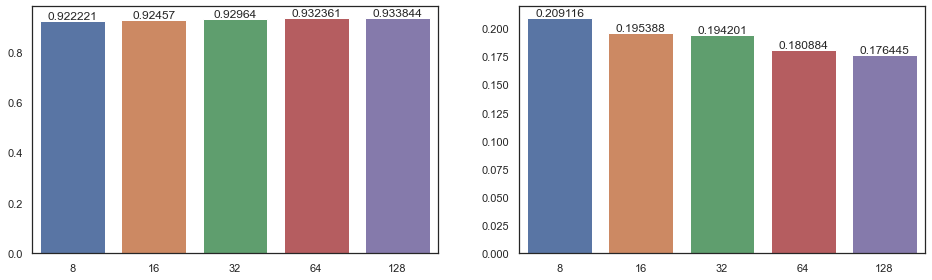

In [58]:
fig, axs = plt.subplots(1,2,figsize=(16,10))
plt.subplot(221)
ax = sns.barplot(x=emb_sizes, y=lstm_test_acc);
ax.bar_label(ax.containers[0]);
plt.subplot(222)
ax = sns.barplot(x=emb_sizes, y=lstm_test_loss);
ax.bar_label(ax.containers[0]);
#plt.show()

In [59]:
lstm = build_lstm_1(32, 5000, 16, 50)        
lstm_1_history = lstm.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=1)              
test_loss, test_acc = lstm.evaluate(test_padded, y_test, verbose=2)

Epoch 1/25
203/203 [==============================] - 3s 11ms/step - loss: 0.3791 - accuracy: 0.8234 - val_loss: 0.2199 - val_accuracy: 0.9128
Epoch 2/25
203/203 [==============================] - 2s 9ms/step - loss: 0.1767 - accuracy: 0.9351 - val_loss: 0.1995 - val_accuracy: 0.9226
Epoch 3/25
203/203 [==============================] - 2s 10ms/step - loss: 0.1413 - accuracy: 0.9476 - val_loss: 0.1773 - val_accuracy: 0.9306
Epoch 4/25
203/203 [==============================] - 2s 10ms/step - loss: 0.1131 - accuracy: 0.9605 - val_loss: 0.1951 - val_accuracy: 0.9244
Epoch 5/25
203/203 [==============================] - 2s 10ms/step - loss: 0.0992 - accuracy: 0.9648 - val_loss: 0.1961 - val_accuracy: 0.9260
Epoch 6/25
203/203 [==============================] - 2s 10ms/step - loss: 0.0813 - accuracy: 0.9715 - val_loss: 0.2062 - val_accuracy: 0.9244
Epoch 7/25
203/203 [==============================] - 2s 10ms/step - loss: 0.0697 - accuracy: 0.9779 - val_loss: 0.2013 - val_accuracy: 0.9261


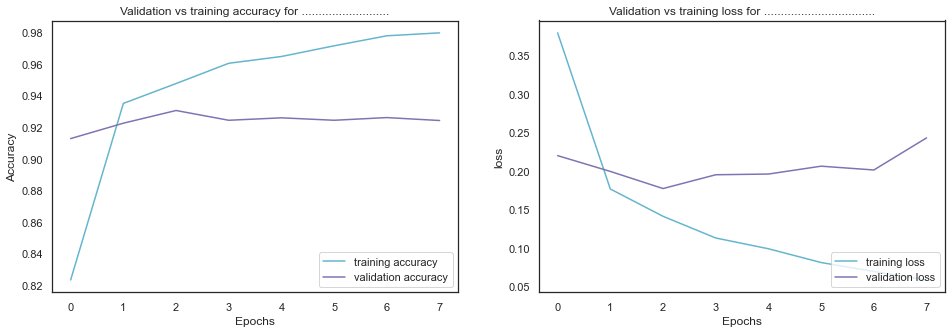

In [60]:
fig, axs = plt.subplots(1,2,figsize=(16,5))
# validation accuracy vs training accuracy for cnn_1
axs[0].plot(lstm_1_history.history['accuracy'],'c') 
axs[0].plot(lstm_1_history.history['val_accuracy'],'m') 
axs[0].set_title('Validation vs training accuracy for ..........................')
axs[0].set_ylabel('Accuracy') 
axs[0].set_xlabel('Epochs')
axs[0].legend(['training accuracy', 'validation accuracy'], loc='lower right')
# validation loss vs training loss for cnn_1
axs[1].plot(lstm_1_history.history['loss'],'c') 
axs[1].plot(lstm_1_history.history['val_loss'],'m') 
axs[1].set_title('Validation vs training loss for .................................')
axs[1].set_ylabel('loss') 
axs[1].set_xlabel('Epochs')
axs[1].legend(['training loss', 'validation loss'], loc='lower right')
plt.show()

In [61]:
print("Accuracy on test data: {acc:.2f}".format(acc=test_acc))
print("Loss on test data: {loss:.2f}".format(loss=test_loss))

Accuracy on test data: 0.93
Loss on test data: 0.18


In [62]:
dropout_lstm = 0.2

In [63]:
lstm_1_drop = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16, input_length=50),
    tf.keras.layers.Bidirectional(LSTM(32, dropout=dropout_lstm, return_sequences=False, activation='tanh')), 
    tf.keras.layers.Dense(1, activation="sigmoid")
  ])
lstm_1_drop.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01, mode='max', restore_best_weights=True)

In [64]:
lstm_1_drop_history = lstm_1_drop.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0)              
test_loss, test_acc = lstm_1_drop.evaluate(test_padded, y_test, verbose=2)

253/253 - 1s - loss: 0.1855 - accuracy: 0.9362 - 1s/epoch - 6ms/step


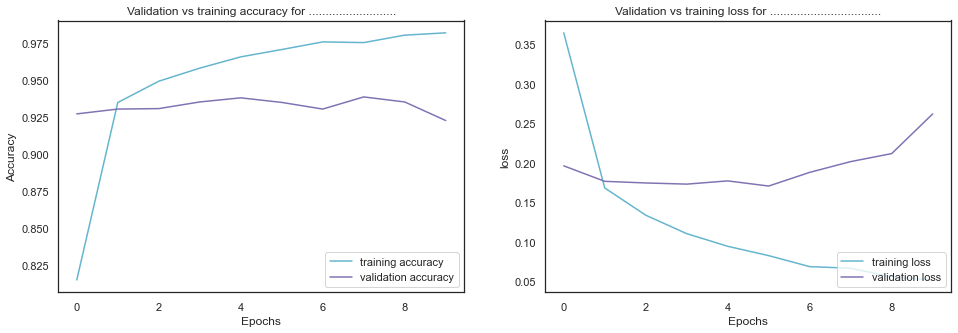

In [65]:
fig, axs = plt.subplots(1,2,figsize=(16,5))
# validation accuracy vs training accuracy for cnn_1
axs[0].plot(lstm_1_drop_history.history['accuracy'],'c') 
axs[0].plot(lstm_1_drop_history.history['val_accuracy'],'m') 
axs[0].set_title('Validation vs training accuracy for ..........................')
axs[0].set_ylabel('Accuracy') 
axs[0].set_xlabel('Epochs')
axs[0].legend(['training accuracy', 'validation accuracy'], loc='lower right')
# validation loss vs training loss for cnn_1
axs[1].plot(lstm_1_drop_history.history['loss'],'c') 
axs[1].plot(lstm_1_drop_history.history['val_loss'],'m') 
axs[1].set_title('Validation vs training loss for .................................')
axs[1].set_ylabel('loss') 
axs[1].set_xlabel('Epochs')
axs[1].legend(['training loss', 'validation loss'], loc='lower right')
plt.show()

In [66]:
# function is defined to build the model with different neurons (passed as a parameter)   
def build_lstm_2(lr):
  lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16, input_length=50),
    tf.keras.layers.LSTM(32, dropout=dropout_lstm, return_sequences=False, activation='tanh'), 
    tf.keras.layers.Dense(1, activation="sigmoid")
  ])
  lstm_2.compile(tf.keras.optimizers.Adam(learning_rate=lr), loss="binary_crossentropy", metrics=['accuracy'])

  return lstm_2

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01, mode='max', restore_best_weights=True)

In [67]:
train_sequences, test_sequences, word_index = tokenize(5000)
train_padded, test_padded = padding(50)

learning_rates = [0.01] 
# nested for loops to iteratively create neural networks with different ... and batch sizes
for y in range(len(learning_rates)):
    lstm = build_lstm_2(learning_rates[y])        
    lstm_history.append(lstm.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=32, callbacks=[callback], verbose=1))                
    test_loss, test_acc = lstm.evaluate(test_padded, y_test, verbose=2)
    lstm_test_loss.append(test_loss)
    lstm_test_acc.append(test_acc)

Epoch 1/25
809/809 [==============================] - 9s 10ms/step - loss: 0.3049 - accuracy: 0.8676 - val_loss: 0.1950 - val_accuracy: 0.9250
Epoch 2/25
809/809 [==============================] - 8s 9ms/step - loss: 0.1823 - accuracy: 0.9300 - val_loss: 0.2135 - val_accuracy: 0.9219
Epoch 3/25
809/809 [==============================] - 7s 9ms/step - loss: 0.1503 - accuracy: 0.9433 - val_loss: 0.2017 - val_accuracy: 0.9238
Epoch 4/25
809/809 [==============================] - 8s 9ms/step - loss: 0.1292 - accuracy: 0.9505 - val_loss: 0.1886 - val_accuracy: 0.9297
Epoch 5/25
809/809 [==============================] - 8s 9ms/step - loss: 0.1189 - accuracy: 0.9542 - val_loss: 0.1986 - val_accuracy: 0.9311
Epoch 6/25
809/809 [==============================] - 8s 9ms/step - loss: 0.1043 - accuracy: 0.9590 - val_loss: 0.2053 - val_accuracy: 0.9261
253/253 - 1s - loss: 0.2000 - accuracy: 0.9237 - 920ms/epoch - 4ms/step


KeyError: 0.01

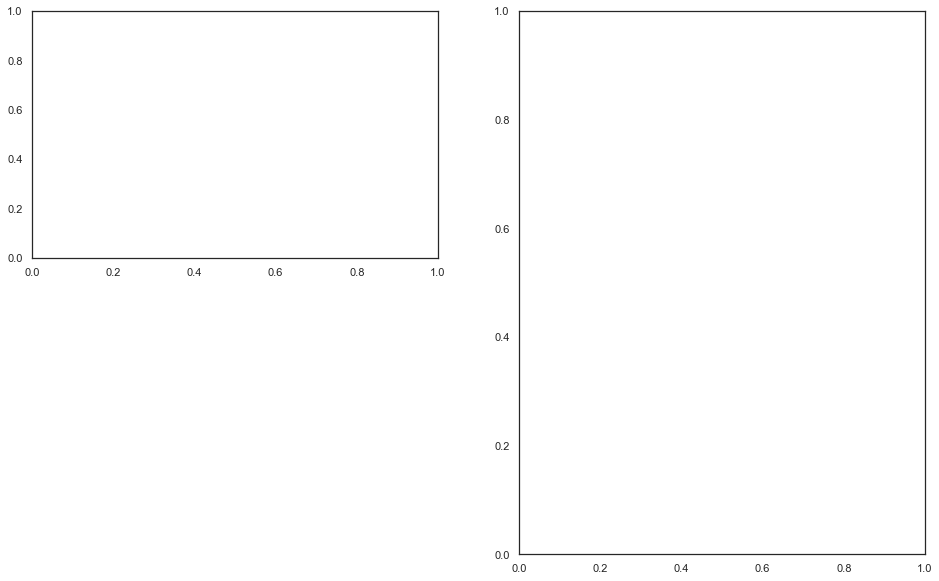

In [68]:
fig, axs = plt.subplots(1,2,figsize=(16,10))
plt.subplot(221)
ax = sns.barplot(x=learning_rates, y=lstm_test_acc);
ax.bar_label(ax.containers[0]);
plt.subplot(222)
ax = sns.barplot(x=learning_rates, y=lstm_test_loss);
ax.bar_label(ax.containers[0]);
#plt.show()

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

layer = tf.keras.layers.Dropout(0.2, name="dropout")(outputs['pooled_output'])
layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(layer)

model = tf.keras.Model(inputs=[text_input], outputs = [layer])
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.fit(x_train, y_train, epochs=5)

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
#top_words = 5000
## truncate and pad input sequences
#max_review_length = 500
## create the model
#embedding_vecor_length = 32
## Final evaluation of the model
#scores = model.evaluate(X_test, y_test, verbose=0)
#print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# do fake and real reviews have the same legnth and polarity distribtuin. check word counts for each 
#do +ve and -ve reviews have the same length and dist
# wordclouds for fake and real 